### Prediction using Echo State Networks (ESNs)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.optimize
import sys
import warnings

from ESN import *
from utils import RMSE

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


In [2]:
# K input units
# N internal units
# L output units

# W_in   : N x K
# W      : N x N
# W_out  : L x (K + N + L)

# n      : nth time step
# u(n)   : activation of input units (K-dim)
# x(n)   : activation of internal units (state) (N-dim)
# y(n)   : activation of output units
# f      : internal unit output function (also referred to as activation function), typically a sigmoid function like tanh

# internal activation is updated by
# x(n+1) = f(W_in u(n+1) + W x(n))
#           f([Nx1] + [Nx1]) -> [Nx1]

# if using leaky integrator neurons:
# x(n+1) = (1-a)x(n) + a*f(W_in u(n+1) + W x(n))

# output computed by
# y(n+1) = f_out(W_out (u(n+1),x(n+1),y(n)))
#           f([Lx1]) -> []

# where (u(n+1),x(n+1),y(n)) is a concatenation

In [3]:
lorenz = np.loadtxt('./datasets/py-lorenz_RK4_100.csv', delimiter=",", dtype='float64')
lorenz_scaled = np.loadtxt('./datasets/py-lorenz-scaled_RK4_100.csv', delimiter=",", dtype='float64')

# data = lorenz[:,1:]
# target = lorenz[1:,1:]
data = lorenz_scaled[:,1:]
target = lorenz_scaled[1:,1:]

train_start=500
train_end=8000
test_start=train_end
test_end=10000

training_target = target[train_start:train_end]
test_target = target[test_start:]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

In [4]:
model = ESNModel(
    inputUnits = 3,
    inputConnGen = lambda m, n : np.random.choice([-1,1], (m,n), p=[0.5, 0.5]),
    internalUnits = 500,
    internalConnGen = lambda m, n : np.random.choice([0,-1,1], (m,n), p=[0.98, 0.01, 0.01]),
    # internalConnGen = lambda m, n : np.random.choice([0,1], (m,n), p=[0.95, 0.05]),
    outputUnits = 3,
    leakRate = 0.9,
    spectralRadius = 0.5,
    regularization = 1e-6,
    activation = np.tanh
)

model.train(data, target, train_indices)

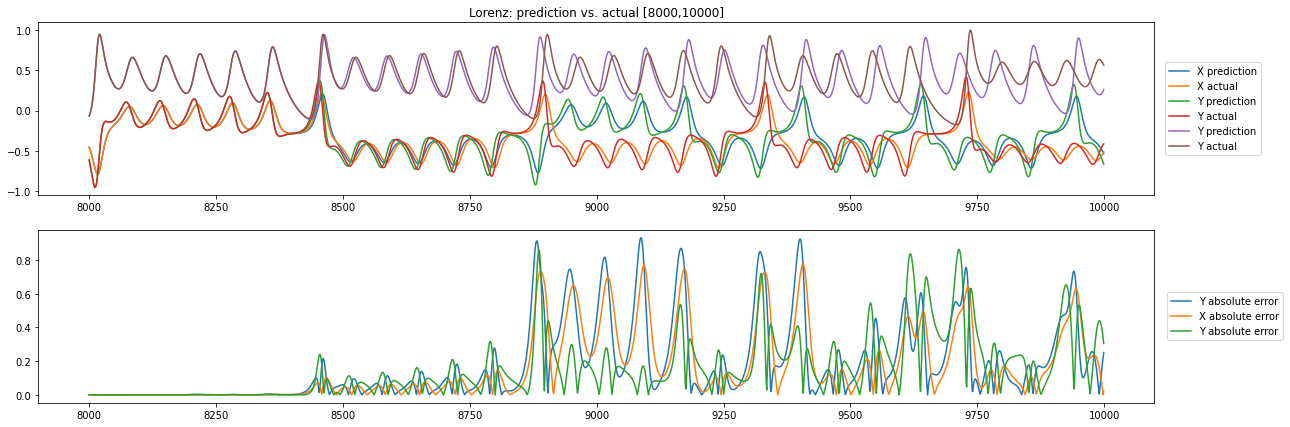

In [5]:
recursive_out = model.recursive_predict(data[train_end-500:train_end], len(test_indices))

data_end = train_end
t_forward = test_end-test_start

fig, axs = plt.subplots(2, figsize=(20, 7))
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,0], label="X prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,0], label="X actual")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,1], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,1], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,1]-data[data_end:data_end+t_forward,1]), label="Y absolute error")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,0]-data[data_end:data_end+t_forward,0]), label="X absolute error")
axs[0].plot(np.arange(data_end,data_end+t_forward), recursive_out[:,2], label="Y prediction")
axs[0].plot(np.arange(data_end,data_end+t_forward), data[data_end:data_end+t_forward,2], label="Y actual")
axs[1].plot(np.arange(data_end,data_end+t_forward), np.abs(recursive_out[:,2]-data[data_end:data_end+t_forward,2]), label="Y absolute error")
axs[0].legend(loc="right", ncol=1, bbox_to_anchor=(1.1,0.5))
axs[1].legend(loc="right", ncol=1, bbox_to_anchor=(1.12,0.5))
axs[0].set_title(f'Lorenz: prediction vs. actual [{data_end},{data_end+t_forward}]')
plt.subplots_adjust(hspace=0.2)
plt.show()